# Magnitude and phase data processing for multi-TE gradient-echo MRI
`Nan-kuei Chen`  
`2021-04-15` 

* __The goal is to demonstrate post-processing methods commonly used for multi-TE gradient-echo imaging data__:
    1. exponential fit of magnitude signals
    2. mapping of magnetic field inhomogeneities (i.e., frequency offset) using the phase signals

## Section 1
* Here we load the magnitude and phase of multi-TE gradient-echo imaging data
* The matrix size for entire data set is $192 \times 192 \times 7 \times 12 $  (in-plane matrix size: 128x128; 7 slices; number of echoes: 12)
* TEs = [2890; 6420; 10360; 14310; 18250; 22200; 26140; 30090; 34030; 37980; 41920; 45870] μsec;

In [2]:
push!(LOAD_PATH,"juliafunction");
using PyPlot
using Read_NIfTI1
using LsqFit

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260
┌ Info: Precompiling Read_NIfTI1 [top-level]
└ @ Base loading.jl:1260
┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1260


In [3]:
filename1 = string("multi_TE_data/20191121_150829T2StarMap2D234FOVs007a1001.nii.gz"); # magnitude data
filename2 = string("multi_TE_data/20191121_150829T2StarMap2D234FOVs008a1001.nii.gz"); # phase data

In [4]:
headerinfo1 = load_niigz_header(filename1);
data1 = load_niigz_data(filename1, headerinfo1);
headerinfo2 = load_niigz_header(filename2);
data2 = load_niigz_data(filename2, headerinfo2);

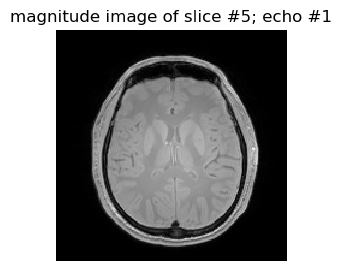

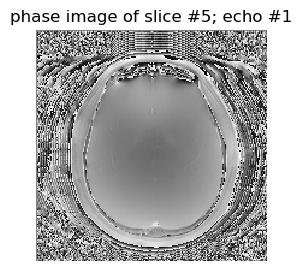

In [5]:
figure(1,figsize=(3,3)); imshow(data1[:,:,5,1]',cmap="gray", interpolation="none", origin="lower"); axis("off"); title("magnitude image of slice #5; echo #1")
figure(2,figsize=(3,3)); imshow(data2[:,:,5,1]',cmap="gray", interpolation="none", origin="lower"); axis("off"); title("phase image of slice #5; echo #1");

In [6]:
# Creating complex-valued images
i = complex(0,1);
data2convert = 2π*(data2/4096.).-π;
complexData = data1 .* exp.(i*(data2convert));

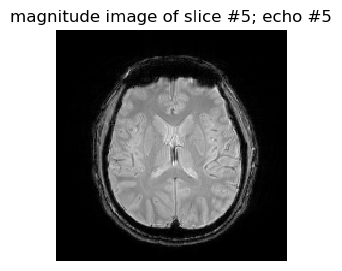

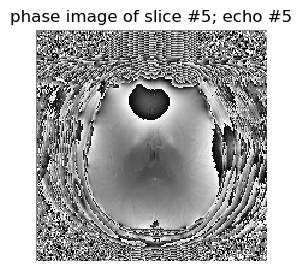

In [7]:
figure(1,figsize=(3,3)); imshow(abs.(complexData[:,:,5,5])',cmap="gray", interpolation="none", origin="lower"); axis("off"); title("magnitude image of slice #5; echo #5")
figure(2,figsize=(3,3)); imshow(angle.(complexData[:,:,5,5])',cmap="gray", interpolation="none", origin="lower"); axis("off"); title("phase image of slice #5; echo #5");

In [8]:
# The TE values corresponding to 12 echo images
μsec = 1e-6;
TEs = [2890; 6420; 10360; 14310; 18250; 22200; 26140; 30090; 34030; 37980; 41920; 45870]μsec;

## Section 2
* Here we fit the magnitude signals to exponential function

Fitting the T2* relaxation time constant

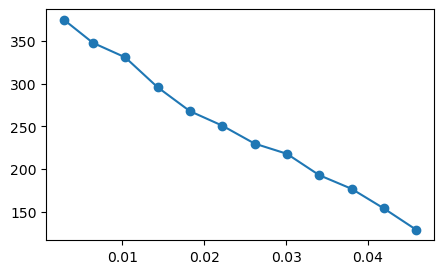

In [9]:
# Here I display magnitude signals of a randomly chosen voxel
chooseX = 110;
chooseY = 140;
tmp1 = abs.(complexData[chooseX,chooseY,5,:]);
figure(1,figsize=(5,3));plot(TEs, tmp1,"o-");

The acquired magnitude signals could be fitted with

$S(t)=M_0 \ \exp(-\frac{t}{T_2}) $

see [https://github.com/nankueichen/T1_and_T2_fitting/blob/master/T2fitting.ipynb](https://github.com/nankueichen/T1_and_T2_fitting/blob/master/T2fitting.ipynb)

In [10]:
T2model(t,p) = p[2]*exp.(-t./p[1]);  #p[1] is the T2 value; p[2] is the M0

T2model (generic function with 1 method)

In [11]:
fit = curve_fit(T2model, TEs, tmp1, [TEs[9],tmp1[1]*2.])
fittedParameters = fit.param;
display((fittedParameters[1],fittedParameters[2]))
fittedSignals = T2model(TEs, fittedParameters);

(0.04470467595423287, 406.7180118640041)

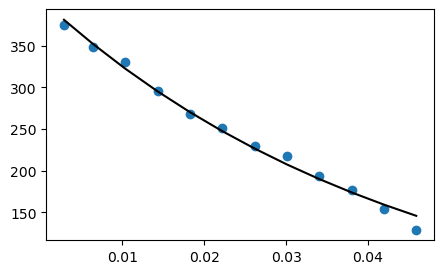

In [12]:
# Displaying both raw signals and fitted signals for the chosen voxel
figure(1,figsize=(5,3));plot(TEs, tmp1,"o", TEs, fittedSignals,"k");

In [13]:
# Fitting signals for all the voxels in slice # 5
T2map = zeros(size(complexData,1), size(complexData,2), size(complexData,3));
PDmap = zeros(size(complexData,1), size(complexData,2), size(complexData,3));

@time for cntz = 5:5 # You should change this line if you want to compute data from all the slices
    for cnty = 1:size(complexData,2)
        for cntx = 1:size(complexData,1)
            tmp1 = abs.(complexData[cntx,cnty,cntz,:]);
            fit = curve_fit(T2model, TEs, tmp1, [TEs[9],tmp1[1]*2.]);
            fittedParameters = fit.param;
            T2map[cntx,cnty,cntz] = fittedParameters[1];
            PDmap[cntx,cnty,cntz] = fittedParameters[2];
        end
    end
end



  8.792860 seconds (46.93 M allocations: 6.153 GiB, 21.52% gc time)


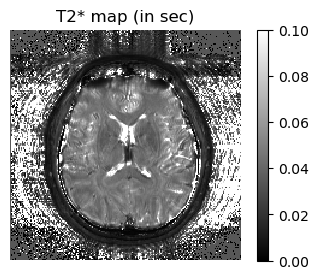

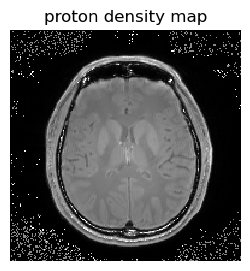

In [14]:
# displaying the results of fitting
figure(1,figsize=(4,3)); imshow(T2map[:,:,5]',cmap="gray", interpolation="none", origin="lower", vmin=0,vmax=0.1); axis("off"); colorbar(); title("T2* map (in sec)")
figure(2,figsize=(3,3)); imshow(PDmap[:,:,5]',cmap="gray", interpolation="none", origin="lower", vmin=0,vmax=1000); axis("off"); title("proton density map");

## Section 3
* Here we compute the frequency offset maps from the phase values of multi-TE gradient-echo images

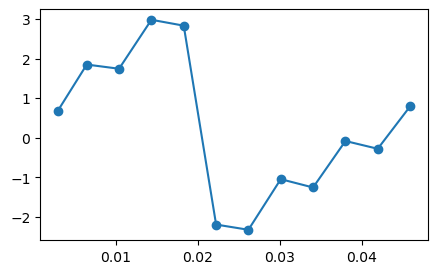

In [15]:
# Displaying phase values of a randomly chosen voxel
chooseX = 110;
chooseY = 140;
tmp1 = angle.(complexData[chooseX,chooseY,5,:]);
figure(1,figsize=(5,3));plot(TEs, tmp1,"o-");

In [16]:
using Pkg
pkg"add https://github.com/platawiec/Unwrap.jl"
using Unwrap

    Cloning git-repo `https://github.com/platawiec/Unwrap.jl`


g: [========================================>]  100.0 %9.3 %================================>        ]  79.0 %

   Updating git-repo `https://github.com/platawiec/Unwrap.jl`


  Resolving package versions...
   Updating `/opt/julia/environments/v1.4/Project.toml`
  [66ceed60] + Unwrap v0.1.0 #master (https://github.com/platawiec/Unwrap.jl)
   Updating `/opt/julia/environments/v1.4/Manifest.toml`
  [66ceed60] + Unwrap v0.1.0 #master (https://github.com/platawiec/Unwrap.jl)
┌ Info: Precompiling Unwrap [66ceed60-733c-11e9-33de-751f162d5676]
└ @ Base loading.jl:1260


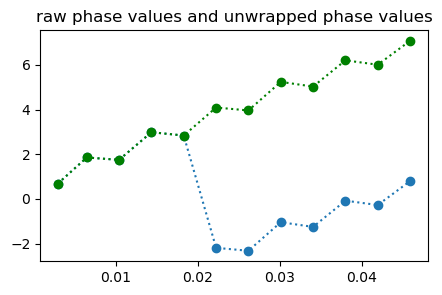

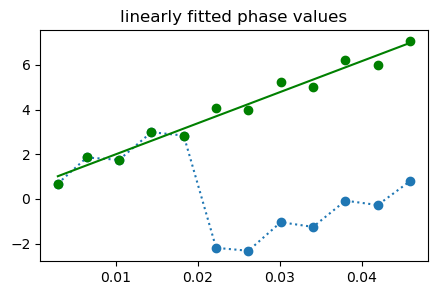

PyObject Text(0.5, 1.0, 'linearly fitted phase values')

In [17]:
# displaying the unwrapped phase value; and the linear fit of unwrapped phase value
tmp2 = unwrap(tmp1);
figure(1,figsize=(5,3));plot(TEs,tmp1, "o:", TEs, tmp2,"go:"); title("raw phase values and unwrapped phase values")

X = zeros(size(TEs)[1],2); 
X[:,1] .= 1.0;  
X[:,2] .= TEs;
coeff = X\tmp2;
fittedLine = coeff[1] .+ coeff[2].*TEs;
figure(2,figsize=(5,3));plot(TEs,tmp1, "o:", TEs, tmp2,"go", TEs, fittedLine, "g"); title("linearly fitted phase values")


In [18]:
# computing frequency offset for each voxel of slice #5, that is the slope of the linearly fitted curve
fieldmap = zeros(size(complexData,1), size(complexData,2), size(complexData,3));
backgroundPhasemap = zeros(size(complexData,1), size(complexData,2), size(complexData,3));
@time for cntz = 5:5
    for cnty = 1:size(complexData,2)
        for cntx = 1:size(complexData,1)
            tmp1 = angle.(complexData[cntx,cnty,cntz,:]);
            tmp2 = unwrap(tmp1);
            coeff = X\tmp2;;
            fieldmap[cntx,cnty,cntz] = coeff[2];
            backgroundPhasemap[cntx,cnty,cntz] = coeff[1];
        end
    end
end


  0.570254 seconds (1.99 M allocations: 2.476 GiB, 37.05% gc time)


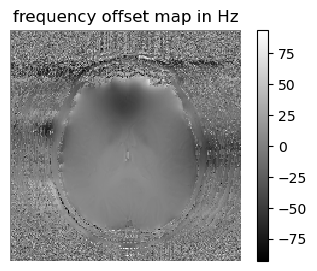

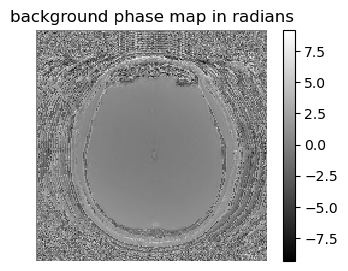

In [19]:
# displaying fitting results (slice # 5)
figure(1,figsize=(4,3)); imshow(-fieldmap[:,:,5]'/(2π),cmap="gray", interpolation="none", origin="lower"); axis("off");colorbar(); title("frequency offset map in Hz")
figure(2,figsize=(4,3)); imshow(backgroundPhasemap[:,:,5]',cmap="gray", interpolation="none", origin="lower"); axis("off");colorbar(); title("background phase map in radians");

### Questions and discussion

* Does the frequency offset map contain any physiologically relevant information?
* How are the magnitude and phase information used to produce susceptibility weigthed imaging?

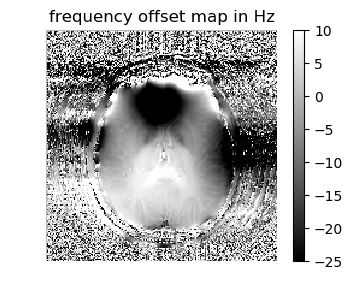

In [19]:
figure(1,figsize=(4,3)); imshow(-fieldmap[:,:,5]'/(2π),cmap="gray", interpolation="none", origin="lower", vmin=-25, vmax=10); axis("off");colorbar();title("frequency offset map in Hz");